## Introdução Prática à Previsão Conforme

Previsão Conforme (em inglês Conformal Prediction) é um método que transforma as previsões pontuais em conjuntos de previsões. Dessa forma, fornece previsões associadas à um nível de confiança estatística, permitindo que sejam medidos e controlados os riscos de uma previsão estar errada.


### Importar Libs

In [24]:
#!pip install -U numpy

In [25]:
#!pip install mapie -use-deprecated=legacy-resolver

In [26]:
import warnings
warnings.filterwarnings("ignore")

import os
import wget
import zipfile
from os.path import exists

import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
from mapie.metrics import classification_mean_width_score

### Download Dataset

In [27]:
bean_data_file = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
base = "https://archive.ics.uci.edu/ml/machine-learning-databases/"
dataset_number = "00602"
filename = "DryBeanDataset.zip"
url = base + dataset_number + "/" + filename
wget.download(url)
zipfile.ZipFile(filename, 'r') .extractall('./')
os.remove(filename)

### Importar Dataset

In [28]:
bean_data_file = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
beans = pd.read_excel(bean_data_file)

In [29]:
beans.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178,173.889,1.197,0.550,28715,190.141,0.764,0.989,0.958,0.913,0.007,0.003,0.834,0.999,SEKER
1,28734,638.018,200.525,182.734,1.097,0.412,29172,191.273,0.784,0.985,0.887,0.954,0.007,0.004,0.910,0.998,SEKER
2,29380,624.110,212.826,175.931,1.210,0.563,29690,193.411,0.778,0.990,0.948,0.909,0.007,0.003,0.826,0.999,SEKER
3,30008,645.884,210.558,182.517,1.154,0.499,30724,195.467,0.783,0.977,0.904,0.928,0.007,0.003,0.862,0.994,SEKER
4,30140,620.134,201.848,190.279,1.061,0.334,30417,195.897,0.773,0.991,0.985,0.971,0.007,0.004,0.942,0.999,SEKER


### Pre-Process and Train Model

In [30]:
# Labels are characters but should be integers for sklearn
le = LabelEncoder()
beans["Class"] = le.fit_transform(beans["Class"])

# Split data into classification target and features
y = beans["Class"]
X = beans.drop("Class", axis = 1)

# Split of training data
X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, train_size=10000, random_state=2)

# From the remaining data, split of test data
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=1000, random_state=42)

# Split remaining into calibration and "new" data
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=1000, random_state=42)

# Fit the model
model = GaussianNB().fit(X_train, y_train)

### Model Evaluation

In [31]:
# Check accuracy
y_pred = model.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean())

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))

Accuracy: 0.758
          BARBUNYA  BOMBAY  CALI  DERMASON  HOROZ  SEKER  SIRA
BARBUNYA        46       0    47         0      6      0     4
BOMBAY           0      33     0         0      0      0     0
CALI            20       0    81         0      3      0     0
DERMASON         0       0     0       223      0     32     9
HOROZ            0       0     4         3    104      0    22
SEKER            2       0     0        26      1    127    22
SIRA             0       0     0        10     10     21   144


### Model Calibration - MAPIE - Naive Approach

In [32]:
# Initialize the MapieClassifier
mapie_score = MapieClassifier(model, cv="prefit", method="naive")

# Calibration step
mapie_score.fit(X_train, y_train)

# Prediction step
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05)

# Removing the alpha-dimension
y_set = np.squeeze(y_set)

In [33]:
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print('Avg. set size: {:.2f}'.format(setsize))

Coverage: 90.32%
Avg. set size: 1.41


### Model Calibration - MAPIE - Score Method

In [34]:
mapie_score = MapieClassifier(model, cv='prefit', method='score')
mapie_score.fit(X_calib, y_calib)
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05)
y_set = np.squeeze(y_set)

In [35]:
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))

Coverage: 96.28%
Avg. set size: 1.83


### Model Calibration - MAPIE - Marginal Coverage x Conditional Coverage

In [36]:
def class_wise_performance(y_new, y_set, classes):
    df = pd.DataFrame()
    # Loop through the classes
    for i in range(len(classes)):  
        # Calculate the coverage and set size for the current class
        ynew = y_new.values[y_new.values == i]
        yscore = y_set[y_new.values == i]
        cov = classification_coverage_score(ynew, yscore)
        size = classification_mean_width_score(yscore)
        # Create a new dataframe with the calculated values
        temp_df = pd.DataFrame({
            "class": [classes[i]],
            "coverage": [cov],
            "avg. set size": [size]
            }, index = [i])
        # Concatenate the new dataframe with the existing one
        df = pd.concat([df, temp_df])
    return(df)

In [37]:
# We can apply this function to our new data and the corresponding prediction sets
print(class_wise_performance(y_new, y_set, le.classes_))

      class  coverage  avg. set size
0  BARBUNYA     0.925          2.138
1    BOMBAY     1.000          1.000
2      CALI     0.966          2.131
3  DERMASON     0.973          1.463
4     HOROZ     0.939          1.873
5     SEKER     0.970          2.017
6      SIRA     0.974          1.974


### Model Calibration - MAPIE - Adaptative Approach

In [38]:
mapie_score = MapieClassifier(model, cv="prefit",
                              method="cumulated_score",
                              random_state=1)

mapie_score.fit(X_calib, y_calib)

MapieClassifier(cv='prefit', estimator=GaussianNB(), method='cumulated_score',
                random_state=1)

In [39]:
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05, include_last_label=True)
y_set = np.squeeze(y_set)

cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))
print(class_wise_performance(y_new, y_set, le.classes_))

Coverage: 96.96%
Avg. set size: 1.91
      class  coverage  avg. set size
0  BARBUNYA     0.931          2.207
1    BOMBAY     1.000          1.000
2      CALI     0.972          2.153
3  DERMASON     0.983          1.512
4     HOROZ     0.947          1.980
5     SEKER     0.983          2.115
6      SIRA     0.974          2.132


In [40]:
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05, include_last_label=False)
y_set = np.squeeze(y_set)
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)

print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))
print(class_wise_performance(y_new, y_set, le.classes_))

Coverage: 81.50%
Avg. set size: 1.18
      class  coverage  avg. set size
0  BARBUNYA     0.534          1.218
1    BOMBAY     1.000          1.000
2      CALI     0.847          1.153
3  DERMASON     0.921          1.163
4     HOROZ     0.803          1.275
5     SEKER     0.732          1.132
6      SIRA     0.849          1.170


In [41]:
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05, include_last_label="randomized")
y_set = np.squeeze(y_set)
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)

print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))
print(class_wise_performance(y_new, y_set, le.classes_))

Coverage: 95.97%
Avg. set size: 1.89
      class  coverage  avg. set size
0  BARBUNYA     0.931          2.213
1    BOMBAY     1.000          2.000
2      CALI     0.960          2.165
3  DERMASON     0.973          1.443
4     HOROZ     0.934          1.980
5     SEKER     0.962          1.979
6      SIRA     0.968          1.981


### Model Calibration - MAPIE - Top-k method for fixed size sets

In [42]:
mapie_score = MapieClassifier(model, cv="prefit", method="top_k")
mapie_score.fit(X_calib, y_calib)

y_pred, y_set = mapie_score.predict(X_new, alpha=0.05)
y_set = np.squeeze(y_set)
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)

print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))
print(class_wise_performance(y_new, y_set, le.classes_))

Coverage: 98.82%
Avg. set size: 3.61
      class  coverage  avg. set size
0  BARBUNYA     0.971          3.414
1    BOMBAY     1.000          7.000
2      CALI     0.983          3.750
3  DERMASON     0.998          4.261
4     HOROZ     0.971          3.000
5     SEKER     0.987          3.000
6      SIRA     1.000          3.000


### Model Calibration - MAPIE - Regularized APS (RAPS) for small sets

In [43]:
mapie_score = MapieClassifier(model, cv="prefit", method="raps")
mapie_score.fit(X_calib, y_calib, size_raps=0.2)

y_pred, y_set = mapie_score.predict(X_new, alpha=0.05, include_last_label="randomized")
y_set = np.squeeze(y_set)
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)

print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))
print(class_wise_performance(y_new, y_set, le.classes_))

Coverage: 95.59%
Avg. set size: 1.87
      class  coverage  avg. set size
0  BARBUNYA     0.925          2.167
1    BOMBAY     1.000          2.000
2      CALI     0.955          2.114
3  DERMASON     0.970          1.461
4     HOROZ     0.926          1.852
5     SEKER     0.966          2.026
6      SIRA     0.961          1.971


### Model Calibration - MAPIE - Group-balanced conformal prediction

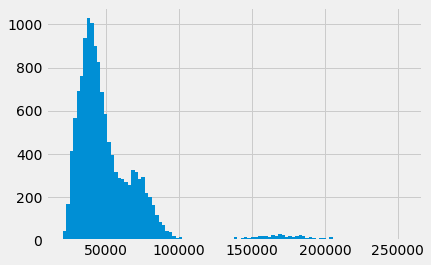

In [44]:
X.Area.hist(bins = 100);
small_bean_index = X_calib.Area < 70000

In [45]:
X_calib_group = X_calib[small_bean_index]
y_calib_group = y_calib[small_bean_index]
mapie_group = MapieClassifier(model, cv="prefit", method="score")
mapie_group.fit(X_calib_group, y_calib_group.values)

MapieClassifier(cv='prefit', estimator=GaussianNB())

In [46]:
group_index = X_new.Area < 70000
X_group = X_new[group_index]
y_pred, y_set = mapie_group.predict(X_group, alpha=0.05)